In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.map_model import MapModelConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder, ScanData,\
    init_map_model
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_model_heatmap, plot_reconstructed_result
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, \
    OptimizePositionState
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import flax.linen as nn
import dataclasses

ROS is not sourced. To enable ROS features, please source it


# Load data

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

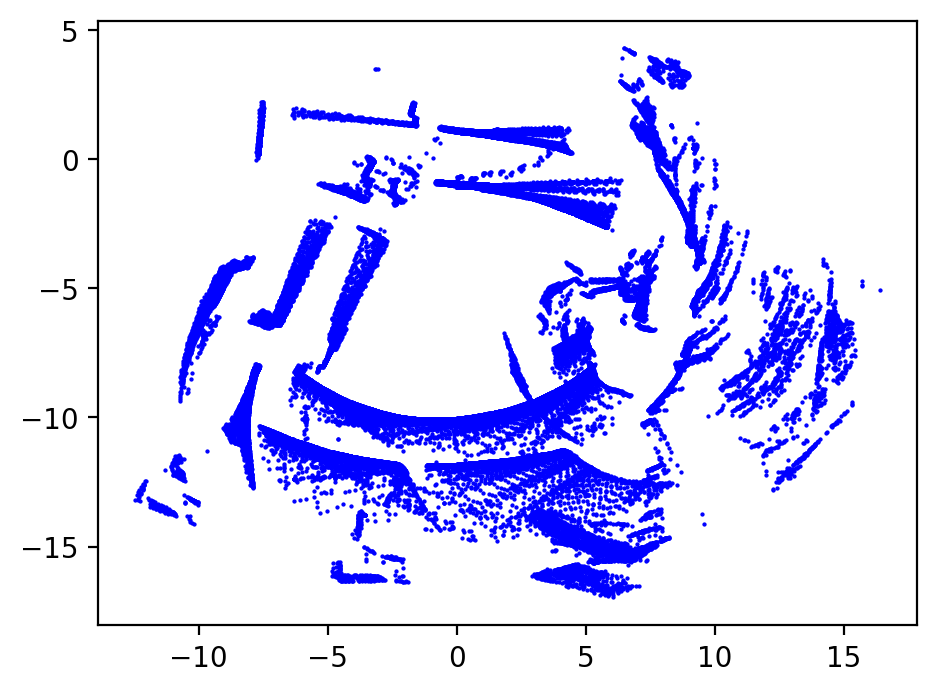

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[0:1000:2], c="blue");

# Mapping

In [45]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=0.2,
    F=4,
    L=32,
    T=4096,
    min_log_resolution=-4,
    max_log_resolution=1.,
    huber_delta=0.5
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=3e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)

learning_index = 200
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
map_model = map_builder.build_map(laser_data, map_position)

Compilation take 3.285313844680786 s


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 35.85it/s]


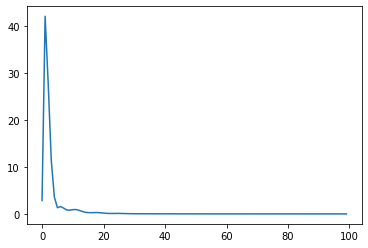

In [46]:
plt.plot(map_builder.loss_history)

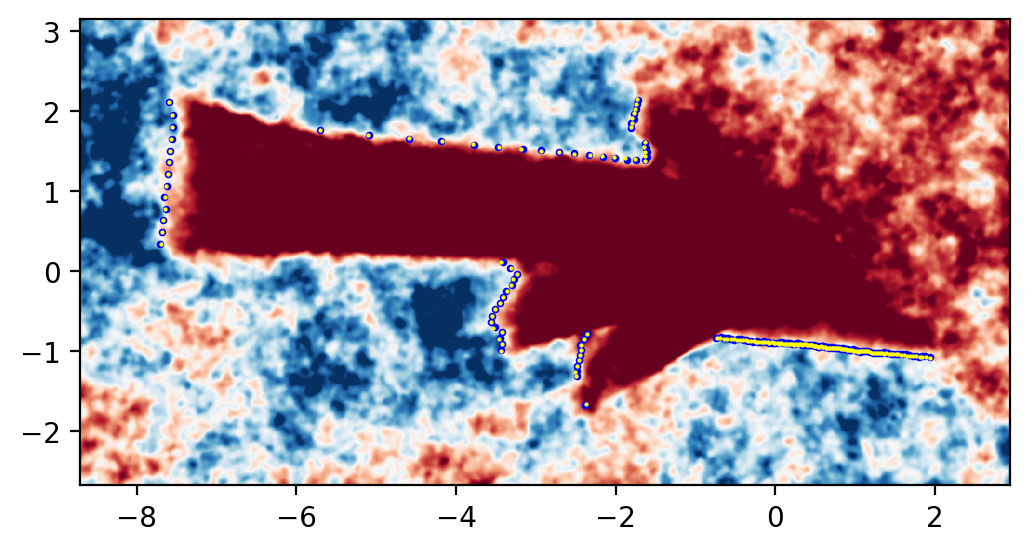

In [47]:
plt.figure(dpi=200)
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), angle=0, 
                   vmin=0, vmax=50.)

plot_reconstructed_result(laser_data_list[learning_index], map_model_config, mlp_model, 
                          map_model, s=3)
show_points(laser_data_list[learning_index:learning_index + 1], c="yellow");

# Find position

In [48]:
position_optimization_config = OptimizePositionConfig(
    iterations=100,
    init_hessian = jnp.diag(jnp.array([200, 200, 200])),
    maximal_clip_norm = 5,
    beta1 = 0.7,
    beta2 = 0.4,
    hessian_adder = jnp.diag(jnp.array([20, 20, 20])),
    learning_rate=0.9,
)
position_optimizer = PositionOptimizer(position_optimization_config, map_model_config, mlp_model)

In [49]:
init_position = jnp.array([0, -1, 2.7])
laser_data = laser_data_list[learning_index + 10]
init_position = jnp.array(laser_data_list[learning_index].odometry_position.as_vec())
optimized_position = position_optimizer.find_position(laser_data, map_model, init_position)

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 47.88it/s]


In [50]:
print(init_position)
print(optimized_position)
print(jnp.array(laser_data.odometry_position.as_vec()))

[ 0.704     0.027    -2.288594]
[ 0.71114904  0.11249618 -2.8392458 ]
[ 0.72      0.037    -2.841691]


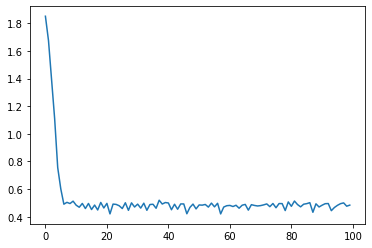

In [51]:
plt.plot(position_optimizer.loss_history)

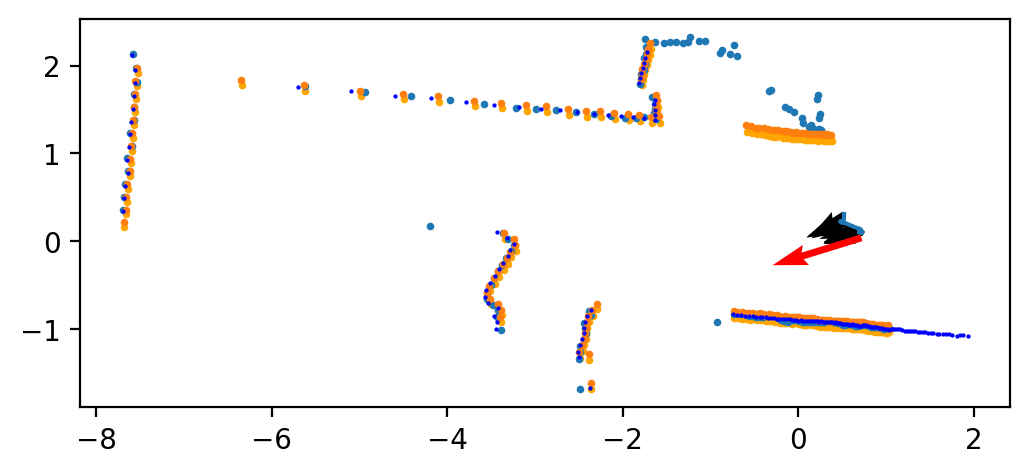

In [52]:
plot_optimization_result(laser_data, map_model_config, map_model, mlp_model, 
                         optimized_position, position_optimizer.position_history)
show_points(laser_data_list[200:201], c="blue");

# Odometry

In [34]:
def ndarray_from_figure(fig):
    byte_array = io.BytesIO()
    fig.savefig(byte_array, format="raw", dpi=200)
    image = np.reshape(np.frombuffer(byte_array.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))

    return image

def make_nf_figure(map_model, shown_laser_data_list, reconstructed_odometry_positions,
                  bounds):
    figure = plt.figure(dpi=200)
    all_points = []
    for laser_data, position in zip(shown_laser_data_list, reconstructed_odometry_positions):
        all_points.append(position.apply(laser_data.as_points()))
    points = np.concatenate(all_points, axis=0)
    bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, 
              np.max(points[:, 1]) + 1)
    plot_model_heatmap(map_model, bounds, mlp_model, vmin=0, vmax=50)
    points = reconstructed_odometry_positions[-1].apply(shown_laser_data_list[-1].as_points())
    plt.scatter(points[:, 0], points[:, 1], s=0.5, c='green')
    plt.gca().set_aspect("equal")
    plt.xlim(bounds[0], bounds[1])
    plt.ylim(bounds[2], bounds[3])
    plt.tight_layout()
    plt.close()
    return figure

def make_animation(shown_images):
    fig = plt.figure(dpi=200)

    def animate(t):
        plt.cla()
        plt.imshow(shown_images[t])
        plt.axis('off')
        if t == len(shown_images) - 1:
            plt.close()

    return matplotlib.animation.FuncAnimation(fig, animate, frames=len(shown_images))

In [35]:
len(laser_data_list)

13631

In [36]:
np.random.seed(200)
tracking_iterations = 7
mapping_iterations = 3
point_count = 200
map_model = init_map_model(mlp_model, map_model_config)

scan_data = ScanData.from_laser_data(laser_data_list[0]).get_random_subset(point_count)
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)
position = jnp.array(laser_data_list[0].odometry_position.as_vec())
map_builder.setup(scan_data.get_random_subset(point_count), map_model, position)

position_optimizer = PositionOptimizer(position_optimization_config, map_model_config, mlp_model)
position_optimizer.setup()

previous_wheel_odometry = Position2D.from_vec(np.zeros(3))
current_position = Position2D.from_vec(np.zeros(3))
reconstructed_odometry_positions = []
shown_images = []
processed_laser_data_list = []
for j in tqdm.tqdm(range(0, 3000, 4)):
    laser_data = laser_data_list[j]
    scan_data = ScanData.from_laser_data(laser_data)
    wheel_odometry = laser_data.odometry_position
    current_position = current_position * previous_wheel_odometry.inv() * wheel_odometry
    previous_wheel_odometry = wheel_odometry
    tracked_position = jnp.array(current_position.as_vec())
    if j != 0:
        for i in range(tracking_iterations):
            tracked_position = position_optimizer.step(tracked_position, 
                                                       map_model, 
                                                       scan_data.get_random_subset(point_count))
    current_position = Position2D.from_vec(np.array(tracked_position))
    reconstructed_odometry_positions.append(current_position)
    for i in range(mapping_iterations):
        map_model = map_builder.step(map_model, 
                                     tracked_position, 
                                     scan_data.get_random_subset(point_count))
    processed_laser_data_list.append(laser_data)
    if j % 5 == 0:
        shown_images.append(ndarray_from_figure(make_nf_figure(
            map_model,
            processed_laser_data_list,
            reconstructed_odometry_positions,
            (-10, 10, -3, 3)
        )))

Compilation take 3.2421646118164062 s


100%|█████████████████████████████████████████| 750/750 [03:00<00:00,  4.14it/s]


In [3]:
# make_animation(shown_images)

In [42]:
def plot_trajectory(trajectory):
    plt.plot(trajectory[:, 0], trajectory[:, 1])
    plt.quiver(trajectory[:, 0], trajectory[:, 1], np.cos(trajectory[:, 2]), np.sin(trajectory[:, 2]))
    plt.gca().set_aspect('equal')

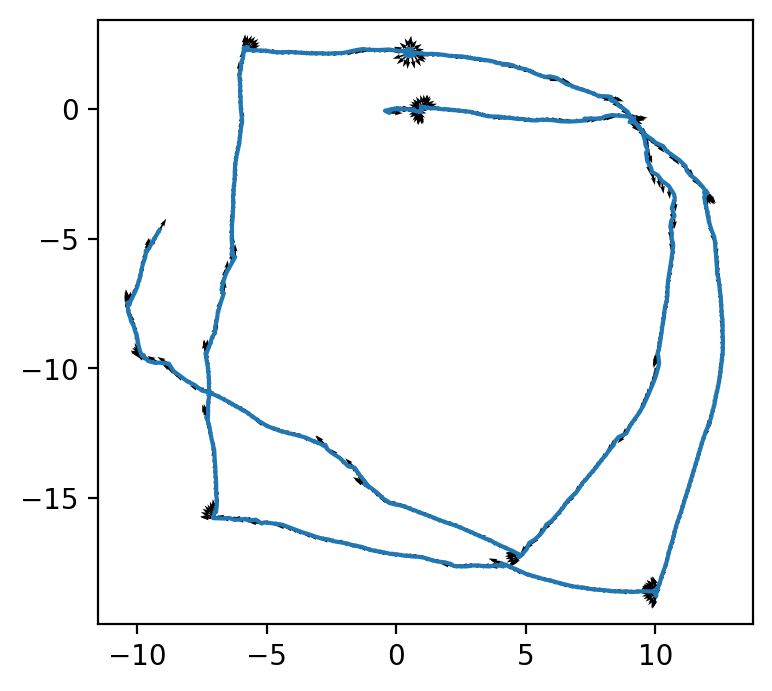

In [74]:
plt.figure(dpi=200)
trajectory = np.array([x.as_vec() for x in reconstructed_odometry_positions])
plot_trajectory(trajectory)

# Odometry with previous position map refinoment

In [38]:
@dataclasses.dataclass
class DataPointBatch(object):
    depths: jnp.array
    angles: jnp.array
    x: jnp.array
    y: jnp.array
    angle: jnp.array
        
    @property
    def scan_data(self):
        return ScanData(depths=self.depths, angles=self.angles)

    @property
    def position(self):
        return jnp.stack([self.x, self.y, self.angle], axis=1)

In [39]:
def get_random_data_point_batch(laser_data_list, scan_count, points_per_scan, positions):
    laser_data_indeces = np.random.choice(np.arange(len(laser_data_list)), scan_count)
    depths = []
    angles = []
    x = []
    y = []
    angle = []
    for i in range(scan_count):
        laser_data = laser_data_list[laser_data_indeces[i]]
        position = positions[laser_data_indeces[i]]
        mask = laser_data.ranges < 10
        indeces = np.arange(mask.shape[0])[mask]
        indeces = np.random.choice(indeces, points_per_scan)
        depths.extend(list(laser_data.ranges[indeces]))
        angles.extend(list(laser_data.angles[indeces]))
        x.extend(list(np.full(indeces.shape[0], position.x)))
        y.extend(list(np.full(indeces.shape[0], position.y)))
        angle.extend(list(np.full(indeces.shape[0], position.rotation)))
    return DataPointBatch(
        depths = jnp.array(depths),
        angles = jnp.array(angles),
        x = jnp.array(x),
        y = jnp.array(y),
        angle = jnp.array(angle)
    )

In [40]:
np.random.seed(200)
tracking_iterations = 7
mapping_iterations = 3
full_mapping_interations = 3
point_count = 200
map_model = init_map_model(mlp_model, map_model_config)

scan_data = ScanData.from_laser_data(laser_data_list[0]).get_random_subset(point_count)
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)
position = jnp.array(laser_data_list[0].odometry_position.as_vec())
map_builder.setup(scan_data.get_random_subset(point_count), map_model, position)

position_optimizer = PositionOptimizer(position_optimization_config, map_model_config, mlp_model)
position_optimizer.setup()

full_map_builder  = MapBuilder(learning_config, map_model_config, mlp_model)
batch = get_random_data_point_batch(laser_data_list, 5, 200, [x.odometry_position for x in laser_data_list])
full_map_builder.setup(batch.scan_data, map_model, batch.position)

previous_wheel_odometry = Position2D.from_vec(np.zeros(3))
current_position = Position2D.from_vec(np.zeros(3))
reconstructed_odometry_positions = []
shown_images = []
processed_laser_data_list = []
for j in tqdm.tqdm(range(0, 3000, 4)):
    laser_data = laser_data_list[j]
    processed_laser_data_list.append(laser_data)
    scan_data = ScanData.from_laser_data(laser_data)
    wheel_odometry = laser_data.odometry_position
    current_position = current_position * previous_wheel_odometry.inv() * wheel_odometry
    previous_wheel_odometry = wheel_odometry
    tracked_position = jnp.array(current_position.as_vec())
    if j != 0:
        for i in range(tracking_iterations):
            tracked_position = position_optimizer.step(tracked_position, 
                                                       map_model, 
                                                       scan_data.get_random_subset(point_count))
    current_position = Position2D.from_vec(np.array(tracked_position))
    reconstructed_odometry_positions.append(current_position)
    for i in range(mapping_iterations):
        map_model = map_builder.step(map_model, 
                                     tracked_position, 
                                     scan_data.get_random_subset(point_count))
    for i in range(full_mapping_interations):
        batch = get_random_data_point_batch(processed_laser_data_list, 5, 200, reconstructed_odometry_positions)
        map_model = full_map_builder.step(map_model,
                                          batch.position,
                                          batch.scan_data)
    if j % 3 == 0:
        shown_images.append(ndarray_from_figure(make_nf_figure(
            map_model,
            processed_laser_data_list,
            reconstructed_odometry_positions,
            (-10, 10, -3, 3)
        )))

Compilation take 2.58123779296875 s
Compilation take 4.181237697601318 s


100%|█████████████████████████████████████████| 750/750 [06:04<00:00,  2.06it/s]


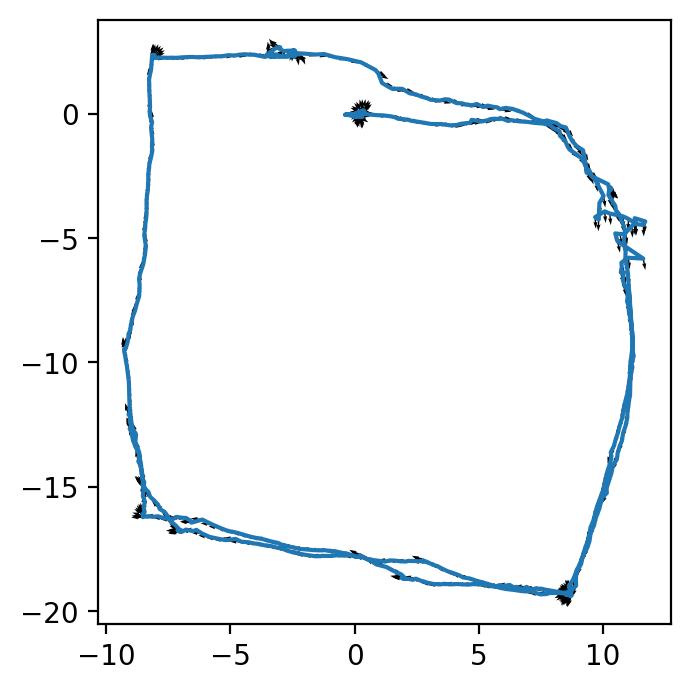

In [53]:
plt.figure(dpi=200)
trajectory = np.array([x.as_vec() for x in reconstructed_odometry_positions])
plot_trajectory(trajectory)

In [2]:
# make_animation(shown_images)